In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [9]:
pip install datasets


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install datasets.load_dataset

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement datasets.load_dataset (from versions: none)
ERROR: No matching distribution found for datasets.load_dataset

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import re

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from datasets import load_dataset


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data Preprocessing (same as before)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()  # Replace word_tokenize with basic split
    return tokens


# Load dataset
dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]



In [6]:
print(dataset["train"][0])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [7]:
# Process training and test data
import nltk

# Force redownload with progress
nltk.download('punkt', quiet=False, raise_on_error=True)
def process_data(data):
    reviews = []
    labels = []
    for sample in tqdm(data):
        labels.append(sample['label'])
        tokens = preprocess_text(sample['text'])
        reviews.append(tokens)
    return reviews, labels

train_reviews, train_labels = process_data(train_data)
test_reviews, test_labels = process_data(test_data)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 25000/25000 [00:03<00:00, 8148.72it/s]


In [8]:
# Vocabulary building
def build_vocab(reviews, max_words=10000):
    word_count = Counter()
    for review in reviews:
        word_count.update(review)
    
    most_common = word_count.most_common(max_words - 2)
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}
    
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    
    return vocab

# Build vocabulary
vocab = build_vocab(train_reviews)
vocab_size = len(vocab)
idx_to_word = {idx: word for word, idx in vocab.items()}



In [9]:
# Sequence encoding
def encode_review(review, vocab, max_len=200):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    return encoded

# Encode reviews
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)



100%|██████████| 25000/25000 [00:01<00:00, 23452.96it/s]


In [10]:
# Dataset and DataLoader
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create train/validation split
train_seq, val_seq, train_labels, val_labels = train_test_split(
    train_sequences, train_labels_tensor, test_size=0.1, random_state=42
)

# Create datasets and dataloaders
train_dataset = IMDbDataset(train_seq, train_labels)
val_dataset = IMDbDataset(val_seq, val_labels)
test_dataset = IMDbDataset(test_sequences, test_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [11]:
# Single Layer LSTM Model
class SingleLayerLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1, :, :])



In [12]:
# Three Layer LSTM Model
class ThreeLayerLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, 
                            dropout=dropout, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)



In [13]:
# Many-to-Many Model (Sequence Classification)
class ManyToManyLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, 
                            dropout=dropout, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        # Use all time steps for classification
        lstm_out = self.dropout(lstm_out)
        # Apply classification to each time step
        return self.fc(lstm_out)




--- Training Single Layer LSTM ---

Epoch 1/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 13.40it/s]


Train Loss: 0.6950 | Train Acc: 51.07%
Val Loss: 0.6954 | Val Acc: 49.53%

Epoch 2/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 14.35it/s]


Train Loss: 0.6899 | Train Acc: 52.88%
Val Loss: 0.6879 | Val Acc: 52.93%


Evaluating: 100%|██████████| 391/391 [00:28<00:00, 13.95it/s]



Test Loss: 0.6907 | Test Acc: 50.90%


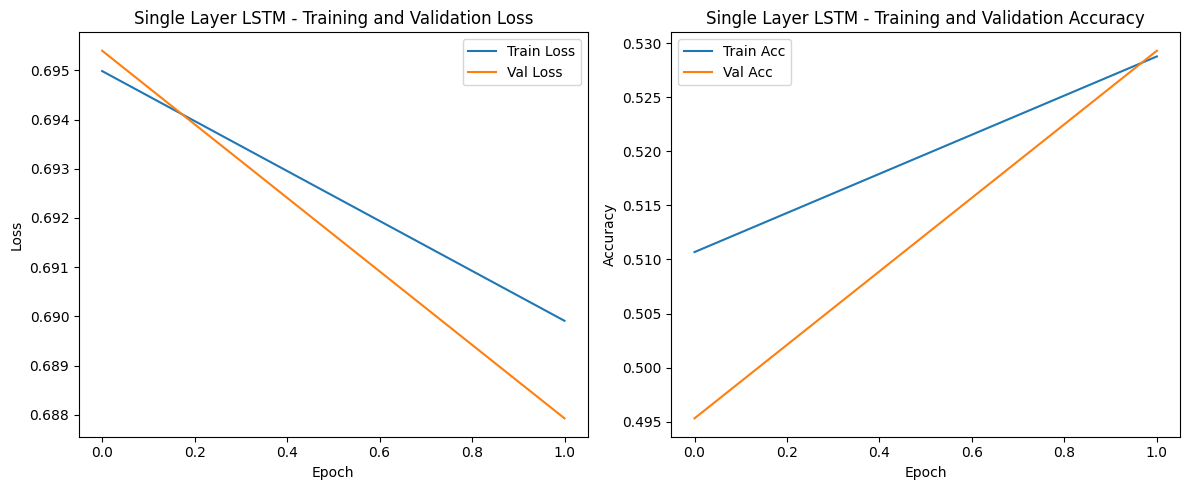


--- Training Three Layer LSTM ---

Epoch 1/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:11<00:00,  3.44it/s]


Train Loss: 0.6941 | Train Acc: 50.55%
Val Loss: 0.6926 | Val Acc: 51.45%

Epoch 2/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.64it/s]


Train Loss: 0.6938 | Train Acc: 49.40%
Val Loss: 0.6925 | Val Acc: 52.23%


Evaluating: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]



Test Loss: 0.6929 | Test Acc: 50.37%


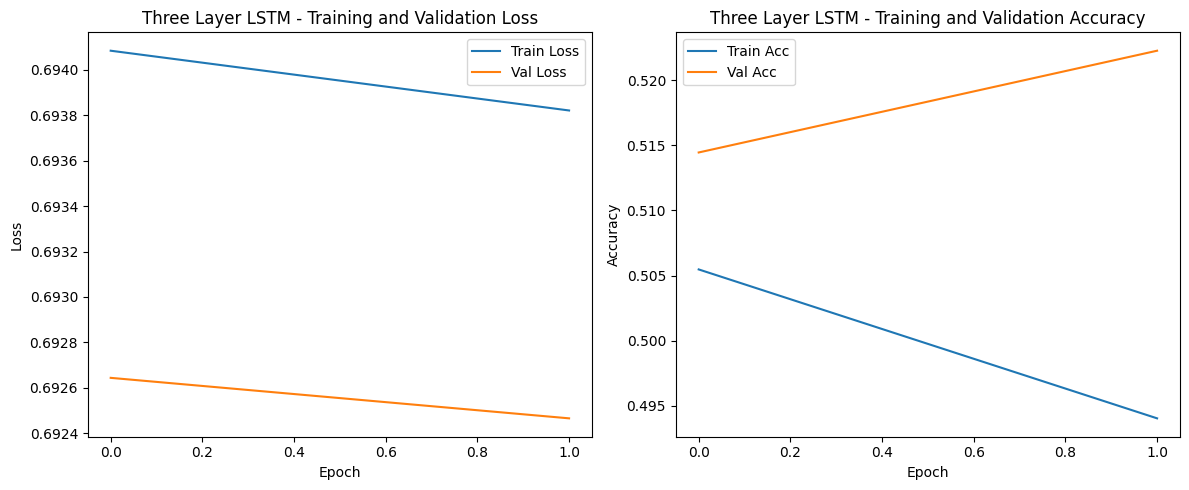


--- Training Many-to-Many LSTM ---

Epoch 1/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:07<00:00,  5.33it/s]


Train Loss: 0.5274 | Train Acc: 72.82%
Val Loss: 0.4232 | Val Acc: 81.48%

Epoch 2/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:07<00:00,  5.53it/s]


Train Loss: 0.3428 | Train Acc: 85.64%
Val Loss: 0.3601 | Val Acc: 84.02%


Evaluating: 100%|██████████| 391/391 [01:12<00:00,  5.41it/s]



Test Loss: 0.3543 | Test Acc: 84.74%


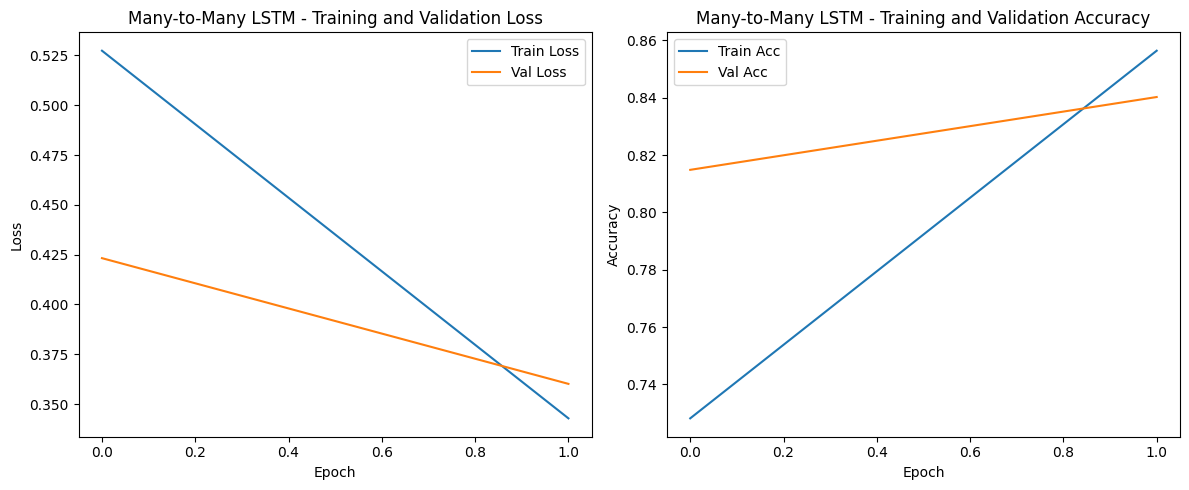

In [14]:
# Training and Evaluation Functions
def train(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in tqdm(iterator, desc="Training"):
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Adjust prediction based on model type
        if isinstance(model, ManyToManyLSTM):
            # For many-to-many, aggregate predictions across time steps
            predictions = model(text)
            predictions = predictions.mean(dim=1).squeeze(1)
        else:
            predictions = model(text).squeeze(1)
        
        loss = criterion(predictions, labels)
        
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct = (predicted_classes == labels).float()
        accuracy = correct.sum() / len(correct)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating"):
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            
            # Adjust prediction based on model type
            if isinstance(model, ManyToManyLSTM):
                predictions = model(text)
                predictions = predictions.mean(dim=1).squeeze(1)
            else:
                predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, labels)
            
            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float()
            accuracy = correct.sum() / len(correct)
            
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Function to train and evaluate a model
def train_and_evaluate_model(model_class, model_name):
    print(f"\n--- Training {model_name} ---")
    
    # Model parameters
    embedding_dim = 100
    hidden_dim = 256
    output_dim = 1
    
    # Initialize model
    model = model_class(
        vocab_size=vocab_size, 
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        output_dim=output_dim
    )
    
    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training parameters
    n_epochs = 2
    
    # Lists to store metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    # Training loop
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch+1}/{n_epochs}")
        print("-" * 20)
        
        # Train
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Evaluate
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print metrics
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Final test evaluation
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

# Train and compare different models
single_layer_model = train_and_evaluate_model(SingleLayerLSTM, "Single Layer LSTM")
three_layer_model = train_and_evaluate_model(ThreeLayerLSTM, "Three Layer LSTM")
many_to_many_model = train_and_evaluate_model(ManyToManyLSTM, "Many-to-Many LSTM")